In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [ ]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [ ]:
len(words)

32033

In [ ]:
# build the vocabulary of characters and mappings to/from integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [86]:
# build the dataset

block_size = 3 # 다음 문자를 예측하는 데 필요한 문자 수에 대한 컨텍스트 길이
X, Y = [], [] # X : 신경망에 대한 입력, Y : 이에 대한 레이블

for w in words[:5]:
  # print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    # print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix]
X = torch.tensor(X)
Y = torch.tensor(Y)

print(X.shape, Y.shape)

torch.Size([32, 3]) torch.Size([32])


In [85]:
# build the dataset

def build_dataset(words):
  block_size = 3 # 다음 문자를 예측하는 데 필요한 문자 수에 대한 컨텍스트 길이
  X, Y = [], [] # X : 신경망에 대한 입력, Y : 이에 대한 레이블

  for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [93]:
C = torch.randn((27, 2))

In [97]:
C[5]
# C[X].shape

torch.Size([32, 3, 2])

In [95]:
# hot encoding

F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([ 0.0919, -0.1116])

In [99]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [100]:
W1 = torch.rand((6, 100))
b1 = torch.randn(100) # bias

In [103]:
emb @ W1 + b1

RuntimeError: mat1 and mat2 shapes cannot be multiplied (96x2 and 6x100)

In [104]:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape
# torch.cat : 어떤 차원을 따라 연결해야 하는지
# [32, 3, 2] => [32, 6]으로 압축함

# 아래는 위 코드와 같은 기능을 수행함
# torch.cat(torch.unbind(emb, 1), 1).shape
# emb.view(32, 6)

torch.Size([32, 6])

In [105]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
h.shape

torch.Size([32, 100])

In [106]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [107]:
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [ ]:
count = logits.exp()

In [ ]:
prob = count / count.sum(1, keepdims=True)

In [ ]:
prob.shape

torch.Size([228146, 27])

In [166]:
loss = -prob[torch.arange(32), Y].log().mean() # y에 의해 주어진 열을 가지고 옴
loss

tensor(21.9263)

## Now made respectable



---



In [162]:
Xtr.shape, Ytr.shape

(torch.Size([182441, 3]), torch.Size([182441]))

In [167]:
# dataset
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [169]:
# 모든 매개변수를 단일 매개변수 목록으로 클러스터링
sum(p.nelement() for p in parameters)

11897

In [171]:
for p in parameters:
  p.requires_grad = True

In [172]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [173]:
lri = []
lossi = []
stepi = []

In [180]:
for i in range(200000):
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 2)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  # print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  # lr = lrs[i]
  # lr = 0.1
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad # 학습속도

  # track stats
  # lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())


print(loss.item())


# 32개 데이터에 과적합 -> 매우 낮은 손실과 높은 예측률


1.8228641748428345


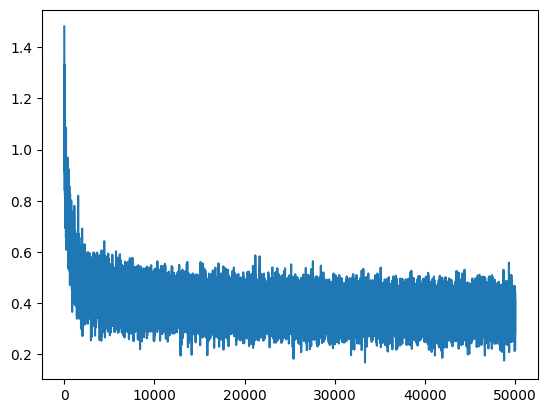

In [175]:
plt.plot(stepi, lossi)
# lr : 학습률이 증가하면서 불안정한 학습률을 보임
# lre[i] : -1(0.1)에서 안정적인 학습률을 보임

In [181]:
# 현재 매개변수 설정이 얼마나 잘 작동하는지 손실 확인
# training loss

emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
# counts = logits.exp()
# prob = counts / counts.sum(1,  keepdims=True)
# loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Ytr) # 위(주석) 세 코드를 수행하는 것과 같음
loss

tensor(2.1031, grad_fn=<NllLossBackward0>)

In [183]:
# 현재 매개변수 설정이 얼마나 잘 작동하는지 손실 확인
# validation loss

emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100) -> emb.view(-1, 6)일 때
logits = h @ W2 + b2 # (32, 27)
# counts = logits.exp()
# prob = counts / counts.sum(1,  keepdims=True)
# loss = -prob[torch.arange(32), Y].log().mean()
loss = F.cross_entropy(logits, Ydev) # 위(주석) 세 코드를 수행하는 것과 같음
loss

tensor(2.1663, grad_fn=<NllLossBackward0>)

In [130]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.4335, grad_fn=<NllLossBackward0>)

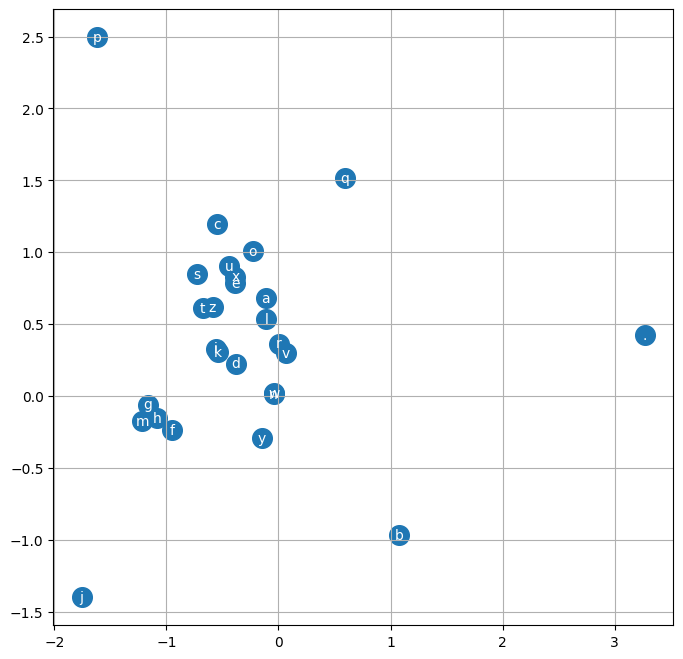

In [184]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [185]:

# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])] # (1, block_size, d)
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

mora.
mayah.
see.
med.
rylle.
emmadiendraeg.
azeem.
melin.
shy.
jenneden.
estanaraelyzion.
kamin.
shubergiagriel.
janie.
jenslee.
pacey.
brence.
ryyah.
fael.
yuma.
